# The Effects of Corporate Tax Policy Reforms  

Published 10/12/19

Contact:  
oliver@taxjustice.net  
[@OliverBarron_](https://twitter.com/OliverBarron_)  



### Project Description

The aim of this project is to develop a programme that calculates the effects of changes in corporate tax policy on tax revenues for different jurisdictions. Then to create an interactive graphic which displays these effects with adjustable variables. This 'create your own policy' graphic will display a range of tax revenue change outcomes based on the percentage of corporations' global profits taxed, and the percentage of taxing rights that are apportioned on sales vs employment. This project is based on paper Cobham et al (2019), and accompanying code - both available [here](https://osf.io/preprints/socarxiv/j3p48/).  

### Context 

The Organisation for Economic Cooperation and Development (OECD) is currently developing corporate tax policy reofrms, as explained by Cobham et al (2019) 

> "the OECD is consulting on the biggest reshaping of international tax rules for ninety years, following an earlier attempt (through phase 1 of the OECD Base Erosion and Profit Shifting initiative, 2013-2015) to patch up the existing tax rules.
Negotiations are ongoing within the OECD/G20 Inclusive Framework on BEPS3 (Inclusive Framework), which brings together 134 countries (both OECD and non- OECD members)."

Comissioned by the Independent Commission for the Reform of International Corporate Taxation (ICRICT), Cobham et al (2019) analyse the corporate tax reform proposal from the OECD. This is compared to proposals from the International Monetary Fund (IMF) and tax justice campaigners. 

### Data

This project uses the data from this paper, which are the current best estimates on corporations sales, employees, and profits, based on country-by-country reporting data released from the US relating to US multinational corporations. The full global data will be released by the OECD in January. This project intends to be update upon this release. 

Further Data:
WEO: World Economic Outlook database (GDP in dollars)
GRD: Government Revenue Dataset (Government corporate and tax revenues)
Data on statutory tax rate: Janský, Petr; Palanský, Miroslav (2018)

***

### Using This Code 

Download the project folder and set this as the working directory. Run the code to generate the GUI. Adjust the variables and outcomes, making sure to press the 'Update Jurisdictions' button after selecting your jurisdictions below the search box. Use code below the GUI to save the results from based on your values of the widgets.

Files:
1. maincode.ipynb - the Jupyter Notebook containing that main code.   
2. mydata.csv - from Cobham et al (2019) code - section 2.1 line 19.  
3. datacode.py - a python script that creates mydata.csv from Cobham et al (2019) code and data. 
4. README - Readme file in markdown 
5. License - License file of GNU GPL

Sections:
1. Load Data  
2. Create Summaries and Prepare Dataset  
3. Create GUI  
4. Testing

Requirements:
- Python 3.0 
- IPython, ipywidgets, matplotlib, numpy, pandas, difflib and os. 

License:
- Licensed under GNU General Public License v3.0. 


## Imports 


In [1]:
import ipywidgets as widgets 
from IPython.display import display
import matplotlib
%matplotlib nbagg 
#matplotlib only works with widgets using this version
import matplotlib.pyplot as plt 
import nbinteract as nbi
import numpy as np 
import pandas as pd
import difflib 

## 1. Load Data

In [2]:
#Importing Dataset
data = pd.read_csv(r'New Data\mydata.csv')

## 2. Create Summaries and Prepare Dataset

First some summaries are created to be used in subsequent calculations calculations, and some variables and values renamed to improve readability in the GUI. The list all_jurisdictions is assembled as this will be required for the jurisdictions selection widget, which must be created before the GUI function update_plot() which will include calculations that reproduce this list. 

Finally in this section, the 0 values in the CIT revenue column are replaced with missing values. It is suspected that these are incorrect (for example this suggests Greece has corporate tax revenues of 0), but also they would cause errors in later calculations. It seems relevant to note here that some there are missing data, particularly for the total tax revenues and corporate tax revenues. These missing values are ignored from calculations, reducing the accuracy of the outcomes from this analysis, however these are the best estimates given the available data.  


In [3]:
#Create world totals objects 
total_revenue = data.loc[data['ISO2']=='World','Revenue'].values[0] 
total_employees = data.loc[data['ISO2']=='World','Number employees'].values[0]
total_profit = data.loc[data['ISO2']=='World','P/L before tax'].values[0]

#rename some variables to improve readability in widgets 
data.loc[data.Inc == 'High Income', 'Inc'] = 'High Income Countries'
data.loc[data.Inc == 'UMICs', 'Inc'] = 'Upper-Middle Income Countries'
data.loc[data.Inc == 'LMICs', 'Inc'] = 'Lower-Middle Income Countries'
data.loc[data.Inc == 'LICs', 'Inc'] = 'Lower Income Countries'
data.loc[data.Inc == 'Tax haven', 'Inc'] = 'Tax Havens' #for country == G7_noUS, set value of Country column to... 

data.rename(columns={'G7_noUS': 'G7 without US', 'G20_noOECD': 'G20 without OECD', 'OECD_noUS': 'OECD without US'}, inplace=True)

#need to create these before creating the jurisdictions widget 
country_groups = ['G7', 'G24', 'G77', 'EU', 'G20', 'OECD', 'G7 without US', 'OECD without US', 'G20 without OECD'] 
inc_groups = ['High Income Countries', 'Upper-Middle Income Countries', 'Lower-Middle Income Countries', 'Lower Income Countries', 'Tax Havens']
countries = data['Country'].tolist() #turn series from column to a list
all_jurisdictions = inc_groups + country_groups + countries #add all lists together

#Remove zeros which affect calculations
data['CIT (AK) USD'] = np.where(data['CIT (AK) USD'] == 0, np.nan, data['CIT (AK) USD']) #have to use np method as column name is not 1 word

# print(np.where(data['CIT (AK) USD'] == 0)) #shows no 0 
# print(data['CIT (AK) USD']) #check column 

## 3. Create Widgets 

The multi_checkbox_widget function is taken from https://gist.github.com/pbugnion/5bb7878ff212a0116f0f1fbc9f431a5c 

Widgets required:

global profits apportioned - a slider that will adjust how much of a corporations total profits are taxed based on the new proposed method.

taxing rights method - will set if the taxing rights are redistributed based on a jurisdictions sales or sales and employment. To do this the values are set at 0 and 0.5, which will be used in the formulas of the outcomes.

outcomes - will set the outcome to be displayed in the plot, again set values that will be selected using a for loop. 

jurisdictions selection - a search box with check boxes, which is a composite of many individual widgets, created using the multi_checkbox_widget function above.

update jurisdictions - a simple click button, this is requried to trigger the update_plot() function, as the jurisdictions selection is not linked to this function via interact. 

Creating Widgets:

In [4]:
def multi_checkbox_widget(descriptions):
    ''' Widget with a search field and lots of checkboxes '''
    search_widget = widgets.Text()
    options_dict = {description: widgets.Checkbox(description=description, value=False) for description in descriptions}
    options = [options_dict[description] for description in descriptions]
    options_widget = widgets.VBox(options, layout={'overflow': 'scroll'})
    multi_select = widgets.VBox([search_widget, options_widget])
 
    # Wire the search field to the checkboxes
    def on_text_change(change):
        search_input = change['new']
        if search_input == '':
            # Reset search field
            new_options = [options_dict[description] for description in descriptions]
        else:
            # Filter by search field using difflib.
            close_matches = difflib.get_close_matches(search_input, descriptions, cutoff=0.0)
            new_options = [options_dict[description] for description in close_matches]
        options_widget.children = new_options

    search_widget.observe(on_text_change, names='value')
    return multi_select




#Widget for percentage of global profits appportioned
style = {'description_width': '100px'}
share_apportioned = widgets.FloatSlider(
    min=0, 
    max=100, 
    value=100, description='Set percentage:', style=style, layout=widgets.Layout(width='50%'))


#Widget for method of taxing rights allocation
allocation_method = widgets.ToggleButtons(
    options=[('Sales', 0), ('Sales & Employment', 0.5)], 
    description='Set method:'
    #tooltips=['Description of Sales', 'Description of Sales & Employment']
                                          )

#Widget for outcome 
outcome = widgets.ToggleButtons(options=[('Dollars', 1),
                                         ('% of Current Tax', 2),
                                         ('% of Current CIT', 3)],
                               description='Set outcome:')

#Jurisdictions selection widget
jurisdictions = (multi_checkbox_widget(all_jurisdictions))    

                                         
#Widget to update jurisdictions
update_jurisdictions = widgets.Button(description='Update Jurisdictions')
    
#testing widgets      
# display(share_apportioned, allocation_method, outcome, update_jurisdictions, jurisdictions) 

## 4. Creating bar plot:

This section sets out what happens when the widgets are adjusted, via the update_plot function, then displays the GUI. 

As can be seen from within the update_plot function, a series of actions are taken upon each adjustment of the widget.
1. The outcome varibales are calculated, using the summary objects, columns from the dataframe, and values of the widgets, which are arguments in the function. 
2. The outcomes are then aggregated to two new levels, at the income group level and country group level. This is done by creating a new dataframe 'new' and then appending this with 'data' to create a data frame 'data_agg' with all outcomes for all jurisdictions and groups. 
3. The lists which are used as the x and y variables are created by subsetting this data frame, with the outcome selected using a for loop with reference to the widget values.  
4. The bar plot is created, adjusting labels before being displayed.

A new function that updates the plot, which is linked to the click of the update jurisdictions button, uses the values from the widgets by using the object 'out'. 

Finally the widgets are groups aesthetically in an accordion, widget is displayed with the update jurisdictions button below. 


<IPython.core.display.Javascript object>


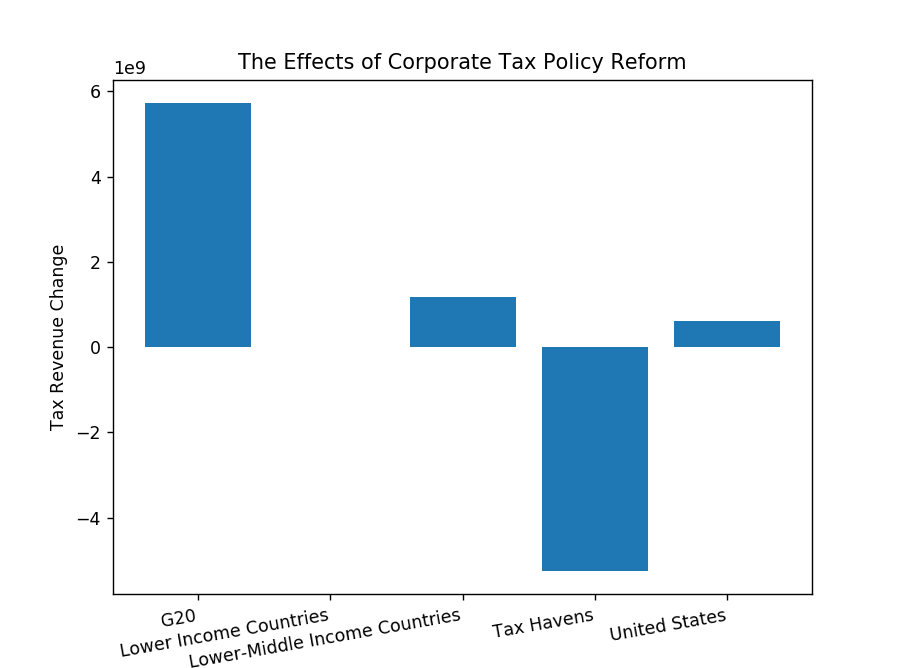

Accordion(children=(FloatSlider(value=100.0, description='Set percentage:', layout=Layout(width='50%'), style=…

Button(description='Update Jurisdictions', style=ButtonStyle())

In [5]:
fig, ax = plt.subplots() #create a figure to create bar plot in
 

def update_plot(share_apportioned, allocation_method, outcome):
    '''function that updates the plot after widgets have been adjusted'''
    
    ax.clear() #clear current plot 
    
    
    #Perform Outcome Calculations
    
    #tax revenue change in dollars
    data['tax_gains_dollars'] = data['CIT'] * (
                                              (total_profit * (
                                                  share_apportioned/100.0))* (
                                                  data['Revenue']/total_revenue
                                                  - allocation_method * (data['Revenue']/total_revenue)
                                                    + allocation_method * (data['Number employees']/total_employees)
                                                                              ) + (1 - (share_apportioned/100))*data['P/L before tax']
                                                                                - data['P/L before tax']
                                              )
   
    #tax revenue change as a % of total tax revenue 
    data['tax_gains_%total_tax'] = (data['tax_gains_dollars']/data['TotTax (X) USD'])*100.0 
    
    #tax revenue change as a % of total CIT revenue 
    data['tax_gains_%cit'] = (data['tax_gains_dollars']/data['CIT (AK) USD'])*100.0 

    
    

    
    #agg for income groups
    new = data.groupby(['Inc']).agg({'tax_gains_dollars' : ['sum'], 'tax_gains_%total_tax' : ['sum'], 'tax_gains_%cit' : ['sum']})
    new = new[['tax_gains_dollars', 'tax_gains_%total_tax', 'tax_gains_%cit']]
    new['Country'] = new.index
    new = new[['Country', 'tax_gains_dollars', 'tax_gains_%total_tax', 'tax_gains_%cit']]
    new.columns = ['Country', 'tax_gains_dollars', 'tax_gains_%total_tax', 'tax_gains_%cit']
    data_agg = new.append(data, sort=True) #new dataframe with aggs
    
    #agg for country groups
    for i in country_groups:       
        new = data.groupby([i]).agg({'tax_gains_dollars' : ['sum'], 'tax_gains_%total_tax' : ['sum'], 'tax_gains_%cit' : ['sum']})
        new = new[['tax_gains_dollars', 'tax_gains_%total_tax', 'tax_gains_%cit']]
        new['Country'] = [0, i]
        new = new[new['Country'] == i]
        new = new[['Country', 'tax_gains_dollars', 'tax_gains_%total_tax', 'tax_gains_%cit']]
        new.columns = ['Country', 'tax_gains_dollars', 'tax_gains_%total_tax', 'tax_gains_%cit']
        data_agg = new.append(data_agg, sort=True)
    
     
    
    #Create lists to plot 
    subset = data_agg.copy() #create a copy of dataframe 
    selected_jurisdictions = [i.description for i in jurisdictions.children[1].children if i.value] #list of selected jurisdictions
    subset = subset[subset.Country.isin(selected_jurisdictions)] #keep rows where country is in selected jurisdictions list 
    jurisdictions_list = subset['Country'] #just the country column 
    
    #create list for y variable based on outcome widget
    if outcome == 1:       
        outcome_list = subset['tax_gains_dollars'] 
    if outcome == 2:
        outcome_list = subset['tax_gains_%total_tax']
    if outcome == 3:
        outcome_list = subset['tax_gains_%cit']
    
    plt.bar(jurisdictions_list, outcome_list) #plot bar graph with lists as y and x variables
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Tax Revenue Change')
    ax.set_xlabel('Jurisdictions')
    ax.set_title('The Effects of Corporate Tax Policy Reform')
    plt.setp(plt.gca().get_xticklabels(), rotation=10, horizontalalignment='right')
    plt.show()
    



#Linking widgets with the update_plot function
out = widgets.interactive(update_plot, share_apportioned=share_apportioned, allocation_method=allocation_method, outcome=outcome)

def when_clicked(self):
    '''function that updates the plot using the values from the interactive widgets'''
    
    update_plot(out.children[0].value, out.children[1].value, out.children[2].value)

update_jurisdictions.on_click(when_clicked)




#Grouping widgets in accordion 
accordion = widgets.Accordion(children=[out.children[0], out.children[1], out.children[2], jurisdictions])
accordion.set_title(0, 'Global Profits Apportioned')
accordion.set_title(1, 'Allocation Method')
accordion.set_title(2, 'Tax Revenue Change As...')
accordion.set_title(3, 'Jurisdictions')


#Display GUI
display(accordion, update_jurisdictions)




In [ ]:
#Save plot  
plt.savefig('TaxReformPlot.png')

## References 

Cobham, Faccio, FitzGerald (2019) Global inequalities in taxing rights: An early evaluation of the OECD tax reform proposals (Preliminary Draft) Available here https://osf.io/preprints/socarxiv/j3p48/